# Download Dataset

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip

--2022-06-21 04:08:27--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.140.67
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.140.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M  22.4MB/s    in 14s     

2022-06-21 04:08:41 (22.6 MB/s) - ‘data_semantics.zip’ saved [327699796/327699796]



In [ ]:
!unzip data_semantics.zip

# Visualization Dataset

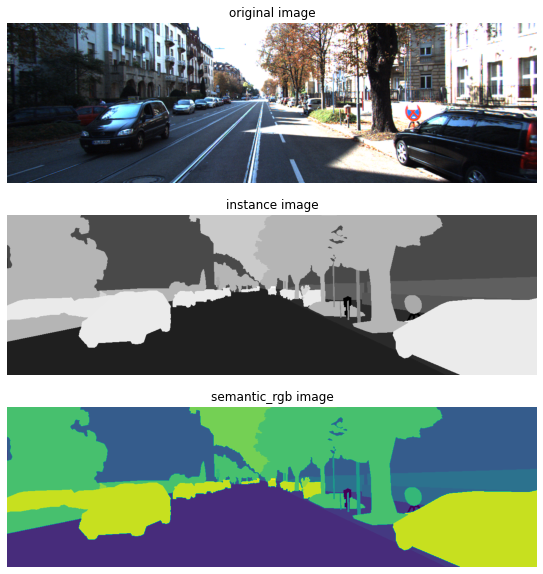

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

image = Image.open('/content/training/image_2/000000_10.png')
instance = Image.open('/content/training/instance/000000_10.png')
semantic = Image.open('/content/training/semantic/000000_10.png')

image = np.array(image)
instance = np.array(instance)
semantic = np.array(semantic)

plt.figure(figsize=(20, 10))
plt.subplot(311)
plt.imshow(image)
plt.title('original image')
plt.axis('off')

plt.subplot(312)
plt.imshow(instance, 'gray')
plt.title('instance image')
plt.axis('off')

plt.subplot(313)
plt.imshow(semantic)
plt.title('semantic_rgb image')
plt.axis('off')
plt.show()

# Define Dataset Class & UNet

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import transforms
from glob import glob

import warnings
warnings.filterwarnings('ignore')

In [22]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, trg_img_dir, transform=None, target_transform=None):
        super().__init__()

        self.img_dir = img_dir
        self.trg_img_dir = trg_img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        trg_img_path = self.trg_img_dir[idx]

        img = Image.open(img_path)
        trg_img = Image.open(trg_img_path)
        trg_img = np.array(trg_img)
        trg_img = (trg_img == 7).astype(np.uint8) * 1 

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            trg_img = self.target_transform(trg_img)
            trg_img = np.array(trg_img)
            trg_img = torch.unsqueeze(torch.tensor(trg_img.astype('float32')), 0)

        
        return img, trg_img

In [16]:
class DConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.dconv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.dconv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.max_pool = nn.MaxPool2d(2)

        self.enc1 = DConv(in_channels, 64)
        self.enc2 = DConv(64, 128)
        self.enc3 = DConv(128, 256)
        self.enc4 = DConv(256, 512)
        
        self.enc5 = nn.Conv2d(512, 1024, 3, 1, 1)
        self.dec5 = nn.Conv2d(1024, 512, 3, 1, 1)

        self.up_pool_4 = nn.ConvTranspose2d(512, 512, 2, 2, 0)
        self.dec4 = DConv(1024, 512)

        self.up_pool_3 = nn.ConvTranspose2d(512, 256, 2, 2, 0)
        self.dec3 = DConv(512, 256)

        self.up_pool_2 = nn.ConvTranspose2d(256, 128, 2, 2, 0)
        self.dec2 = DConv(256, 128)

        self.up_pool_1 = nn.ConvTranspose2d(128, 64, 2, 2, 0)
        self.dec1 = DConv(128, 64)

        self.conv = nn.Conv2d(64, out_channels, 1, 1, 0)
        
    def forward(self, x):
        enc1 = self.enc1(x)
        pool1 = self.max_pool(enc1)
        enc2 = self.enc2(pool1)
        pool2 = self.max_pool(enc2)
        enc3 = self.enc3(pool2)
        pool3 = self.max_pool(enc3)
        enc4 = self.enc4(pool3)
        pool4 = self.max_pool(enc4)
        
        enc5 = self.enc5(pool4)
        dec5 = self.dec5(enc5)

        up_pool4 = self.up_pool_4(dec5)
        cat4 = torch.cat((up_pool4, enc4), dim=1)
        dec4 = self.dec4(cat4)

        up_pool3 = self.up_pool_3(dec4)
        cat3 = torch.cat((up_pool3, enc3), dim=1)
        dec3 = self.dec3(cat3)

        up_pool2 = self.up_pool_2(dec3)
        cat2 = torch.cat((up_pool2, enc2), dim=1)
        dec2 = self.dec2(cat2)

        up_pool1 = self.up_pool_1(dec2)
        cat1 = torch.cat((up_pool1, enc1), dim=1)
        dec1 = self.dec1(cat1)

        out = self.conv(dec1)
        out = torch.sigmoid(out)
        
        return out

# Define Iou function

In [5]:
def iou(preds, targets):
    smooth = 1e-5

    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    intersection = np.sum(np.logical_and(targets, preds))
    union = np.sum(np.logical_or(targets, preds))
    iou_score = (torch.tensor(intersection) + smooth)  / (torch.tensor(union) + smooth)

    return iou_score

# Set Train Loader

In [6]:
batch_size = 10
lr = 1e-2
epochs = 50

In [24]:
img_dir = glob('/content/training/image_2/*.png')
trg_img_dir = glob('/content/training/semantic/*.png')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

target_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
])

dataset = CustomDataset(img_dir, trg_img_dir, transform, target_transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

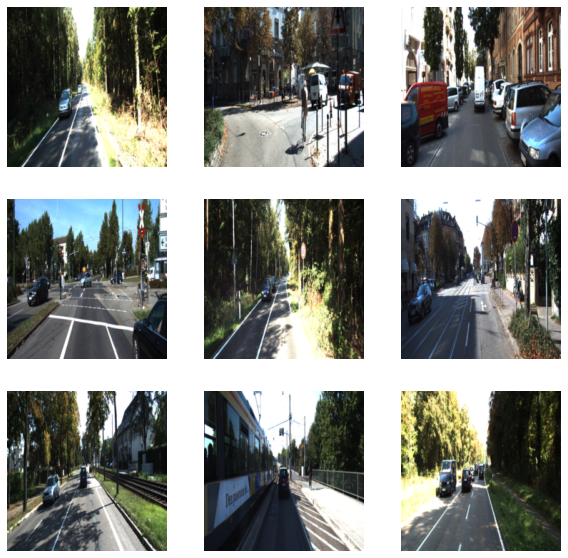

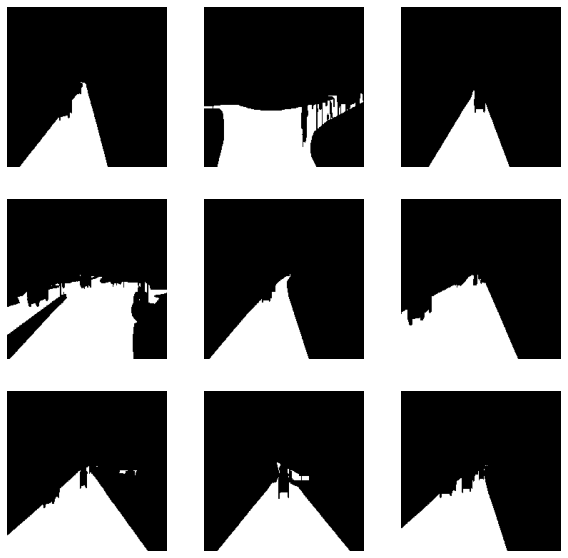

In [27]:
sample = next(iter(train_loader))
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(torch.permute(sample[0][i], (1, 2, 0)))
    plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(torch.squeeze(sample[1][i], 0), 'gray')
    plt.axis('off')
plt.show()

# Set Model, Optimizer, Loss Function

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet(3, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

# Training

[Epoch 1/50]
    [Step : 5/20] Loss: 0.49617519974708557 Iou: 0.41196978092193604
    [Step : 10/20] Loss: 0.43347012996673584 Iou: 0.14498014748096466
    [Step : 15/20] Loss: 0.38034504652023315 Iou: 0.5433633923530579
    [Step : 20/20] Loss: 0.29810822010040283 Iou: 0.6449501514434814


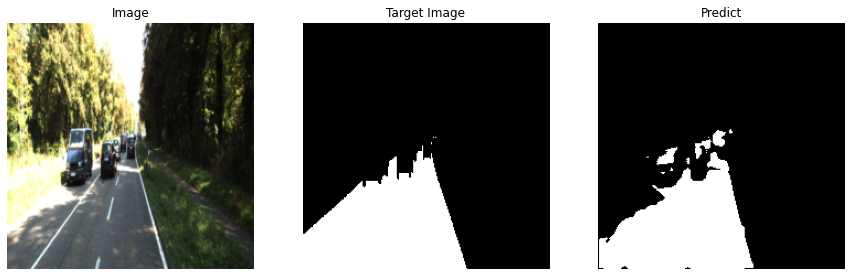

[Epoch 2/50]
    [Step : 5/20] Loss: 0.19464948773384094 Iou: 0.7212295532226562
    [Step : 10/20] Loss: 0.22919681668281555 Iou: 0.6399349570274353
    [Step : 15/20] Loss: 0.19035957753658295 Iou: 0.7246031165122986
    [Step : 20/20] Loss: 0.26067373156547546 Iou: 0.6326174736022949


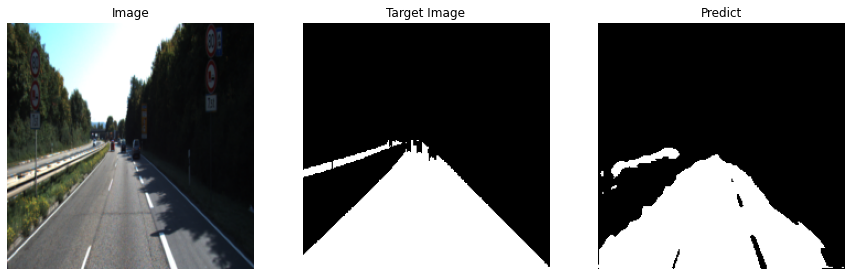

[Epoch 3/50]
    [Step : 5/20] Loss: 0.17471827566623688 Iou: 0.7283453345298767
    [Step : 10/20] Loss: 0.22759851813316345 Iou: 0.7148145437240601
    [Step : 15/20] Loss: 0.19872987270355225 Iou: 0.7122531533241272
    [Step : 20/20] Loss: 0.20872589945793152 Iou: 0.6985602378845215


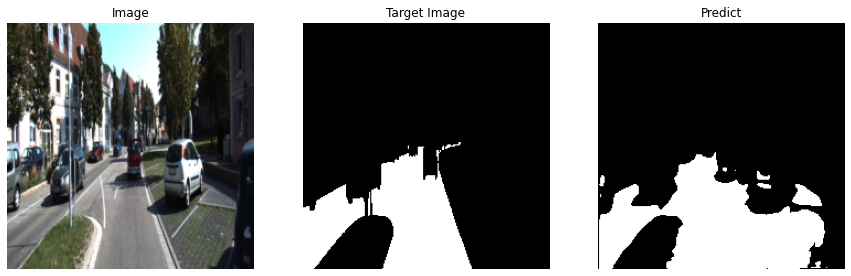

[Epoch 4/50]
    [Step : 5/20] Loss: 0.18198777735233307 Iou: 0.7519892454147339
    [Step : 10/20] Loss: 0.28948044776916504 Iou: 0.5524473190307617
    [Step : 15/20] Loss: 0.18259449303150177 Iou: 0.7305499911308289
    [Step : 20/20] Loss: 0.1817462146282196 Iou: 0.759760856628418


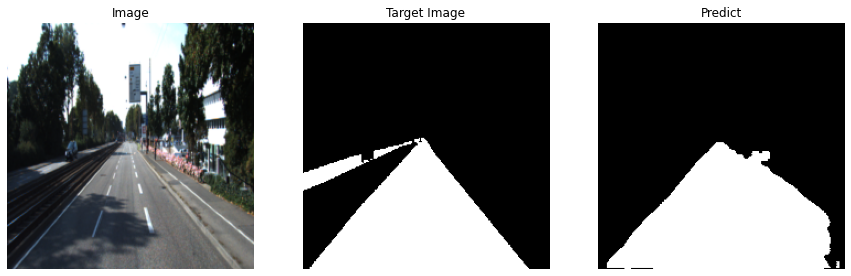

[Epoch 5/50]
    [Step : 5/20] Loss: 0.14712508022785187 Iou: 0.7570590972900391
    [Step : 10/20] Loss: 0.18431146442890167 Iou: 0.7319040894508362
    [Step : 15/20] Loss: 0.16487714648246765 Iou: 0.7726763486862183
    [Step : 20/20] Loss: 0.1547665297985077 Iou: 0.7411947846412659


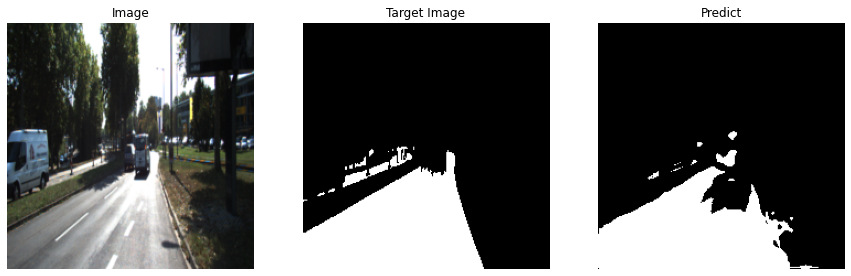

[Epoch 6/50]
    [Step : 5/20] Loss: 0.18460850417613983 Iou: 0.7340326309204102
    [Step : 10/20] Loss: 0.2711038887500763 Iou: 0.5880556702613831
    [Step : 15/20] Loss: 0.25041019916534424 Iou: 0.7002860307693481
    [Step : 20/20] Loss: 0.17409738898277283 Iou: 0.7501253485679626


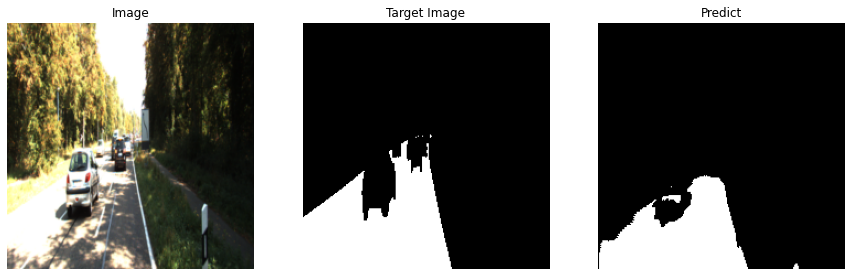

[Epoch 7/50]
    [Step : 5/20] Loss: 0.20574964582920074 Iou: 0.6814751029014587
    [Step : 10/20] Loss: 0.15776735544204712 Iou: 0.7492677569389343
    [Step : 15/20] Loss: 0.17856495082378387 Iou: 0.6952483654022217
    [Step : 20/20] Loss: 0.20014825463294983 Iou: 0.7127770781517029


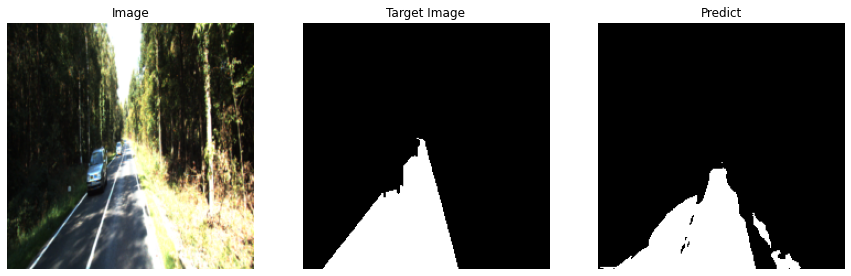

[Epoch 8/50]
    [Step : 5/20] Loss: 0.16945880651474 Iou: 0.7437527179718018
    [Step : 10/20] Loss: 0.22912929952144623 Iou: 0.6361474990844727
    [Step : 15/20] Loss: 0.15504753589630127 Iou: 0.7774823307991028
    [Step : 20/20] Loss: 0.1472671926021576 Iou: 0.7832645177841187


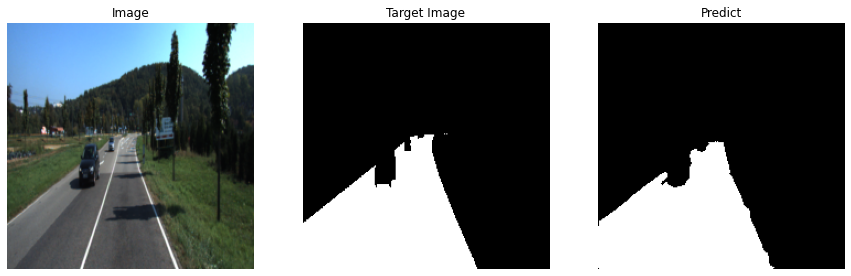

[Epoch 9/50]
    [Step : 5/20] Loss: 0.13820308446884155 Iou: 0.7663662433624268
    [Step : 10/20] Loss: 0.14108958840370178 Iou: 0.8023554682731628
    [Step : 15/20] Loss: 0.1509328931570053 Iou: 0.7653480172157288
    [Step : 20/20] Loss: 0.12372208386659622 Iou: 0.7940186858177185


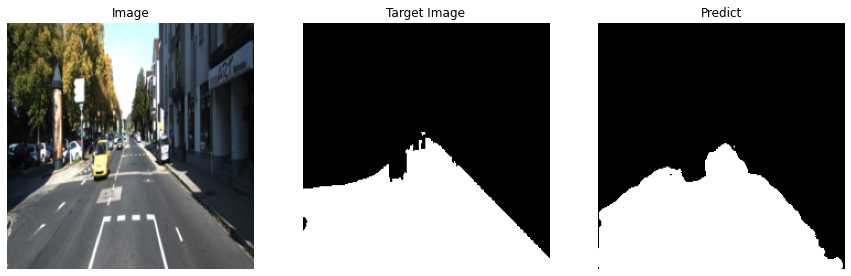

[Epoch 10/50]
    [Step : 5/20] Loss: 0.20030584931373596 Iou: 0.6873135566711426
    [Step : 10/20] Loss: 0.20057804882526398 Iou: 0.6936642527580261
    [Step : 15/20] Loss: 0.16497811675071716 Iou: 0.7771159410476685
    [Step : 20/20] Loss: 0.148060604929924 Iou: 0.7777095437049866


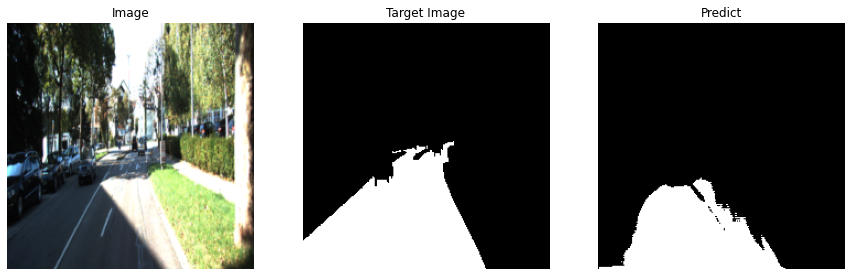

[Epoch 11/50]
    [Step : 5/20] Loss: 0.15377362072467804 Iou: 0.7435593605041504
    [Step : 10/20] Loss: 0.16990604996681213 Iou: 0.6959345936775208
    [Step : 15/20] Loss: 0.2036880999803543 Iou: 0.7392368316650391
    [Step : 20/20] Loss: 0.1303650289773941 Iou: 0.8004118800163269


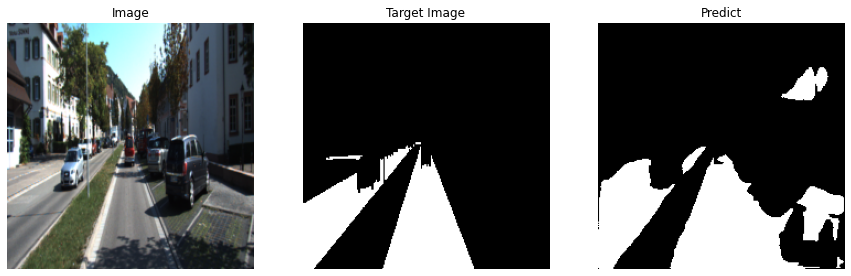

[Epoch 12/50]
    [Step : 5/20] Loss: 0.16759569942951202 Iou: 0.7298665046691895
    [Step : 10/20] Loss: 0.13793900609016418 Iou: 0.7945595383644104
    [Step : 15/20] Loss: 0.18599379062652588 Iou: 0.6979232430458069
    [Step : 20/20] Loss: 0.11223402619361877 Iou: 0.8355244398117065


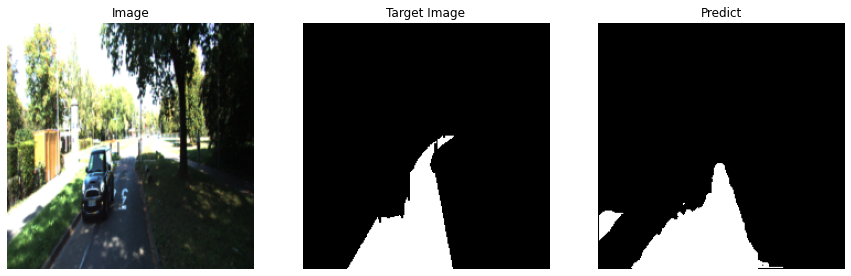

[Epoch 13/50]
    [Step : 5/20] Loss: 0.11399932950735092 Iou: 0.8383458256721497
    [Step : 10/20] Loss: 0.11405892670154572 Iou: 0.8266637921333313
    [Step : 15/20] Loss: 0.16710317134857178 Iou: 0.7525787353515625
    [Step : 20/20] Loss: 0.17394541203975677 Iou: 0.7191069722175598


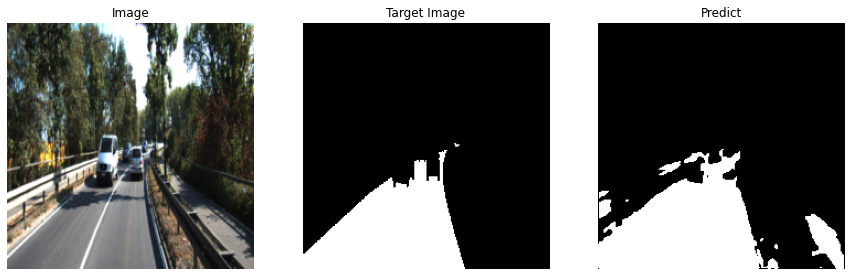

[Epoch 14/50]
    [Step : 5/20] Loss: 0.13439089059829712 Iou: 0.7859591841697693
    [Step : 10/20] Loss: 0.1588738113641739 Iou: 0.7845194935798645
    [Step : 15/20] Loss: 0.12919586896896362 Iou: 0.8264009952545166
    [Step : 20/20] Loss: 0.13806740939617157 Iou: 0.7720187902450562


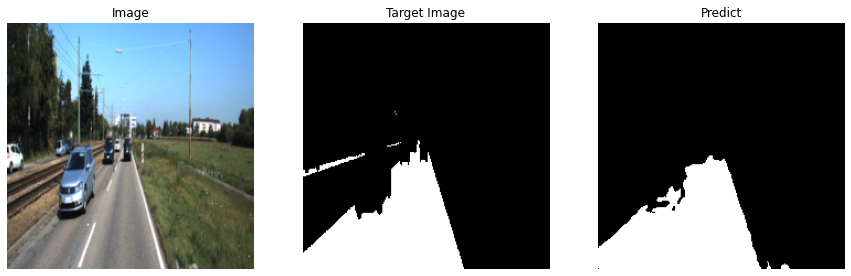

[Epoch 15/50]
    [Step : 5/20] Loss: 0.14408278465270996 Iou: 0.7871699929237366
    [Step : 10/20] Loss: 0.13594341278076172 Iou: 0.7985948324203491
    [Step : 15/20] Loss: 0.1006171777844429 Iou: 0.8293566107749939
    [Step : 20/20] Loss: 0.20219393074512482 Iou: 0.6723736524581909


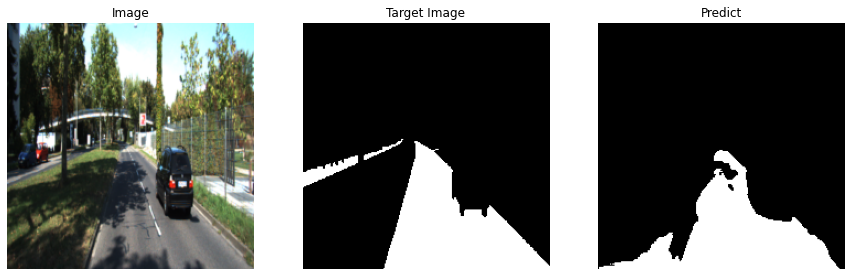

[Epoch 16/50]
    [Step : 5/20] Loss: 0.18875159323215485 Iou: 0.7189887166023254
    [Step : 10/20] Loss: 0.13224001228809357 Iou: 0.7939409017562866
    [Step : 15/20] Loss: 0.1306842863559723 Iou: 0.7709386348724365
    [Step : 20/20] Loss: 0.18871711194515228 Iou: 0.7080164551734924


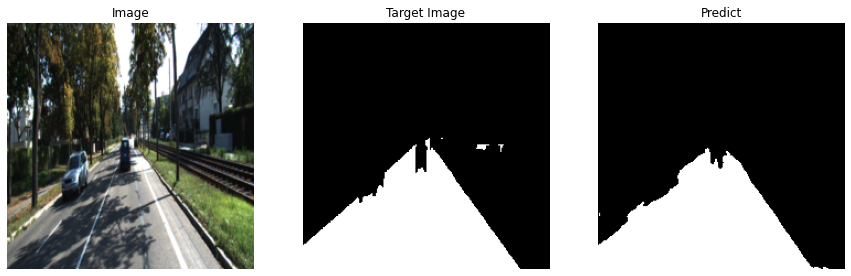

[Epoch 17/50]
    [Step : 5/20] Loss: 0.10981021076440811 Iou: 0.8369389176368713
    [Step : 10/20] Loss: 0.11323264986276627 Iou: 0.8341248035430908
    [Step : 15/20] Loss: 0.1631018966436386 Iou: 0.6933580040931702
    [Step : 20/20] Loss: 0.15650463104248047 Iou: 0.7758384943008423


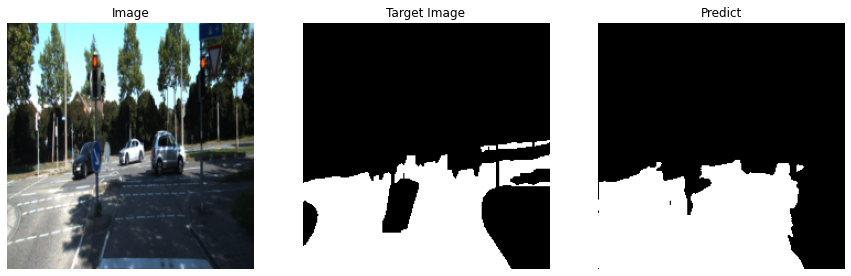

[Epoch 18/50]
    [Step : 5/20] Loss: 0.1608491837978363 Iou: 0.7338733077049255
    [Step : 10/20] Loss: 0.19725792109966278 Iou: 0.7161014676094055
    [Step : 15/20] Loss: 0.1516105830669403 Iou: 0.7459166646003723
    [Step : 20/20] Loss: 0.09825517237186432 Iou: 0.8547331690788269


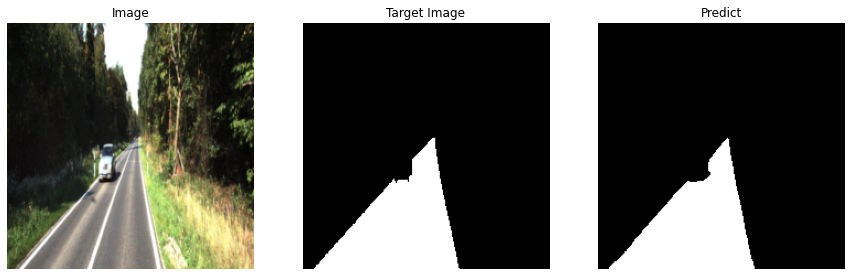

[Epoch 19/50]
    [Step : 5/20] Loss: 0.130320206284523 Iou: 0.7923571467399597
    [Step : 10/20] Loss: 0.1135065034031868 Iou: 0.8409033417701721
    [Step : 15/20] Loss: 0.1240406259894371 Iou: 0.7849777340888977
    [Step : 20/20] Loss: 0.10366908460855484 Iou: 0.820293128490448


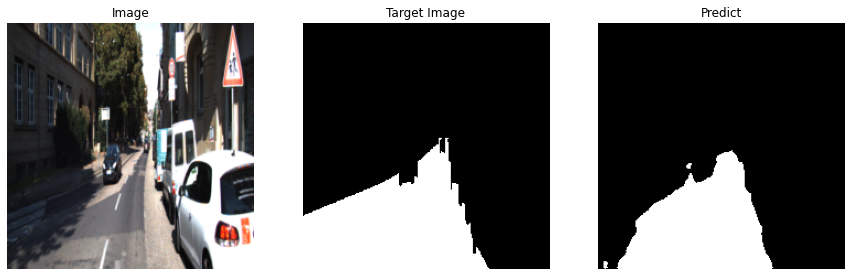

[Epoch 20/50]
    [Step : 5/20] Loss: 0.12500931322574615 Iou: 0.8115372061729431
    [Step : 10/20] Loss: 0.11528560519218445 Iou: 0.7990353107452393
    [Step : 15/20] Loss: 0.0987444594502449 Iou: 0.8481202721595764
    [Step : 20/20] Loss: 0.12904055416584015 Iou: 0.7998281717300415


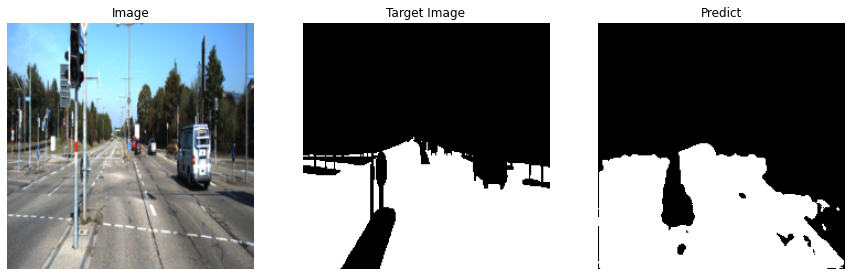

[Epoch 21/50]
    [Step : 5/20] Loss: 0.09583644568920135 Iou: 0.864270031452179
    [Step : 10/20] Loss: 0.1710817813873291 Iou: 0.7359468936920166
    [Step : 15/20] Loss: 0.12308357656002045 Iou: 0.7975409030914307
    [Step : 20/20] Loss: 0.11979727447032928 Iou: 0.7671220898628235


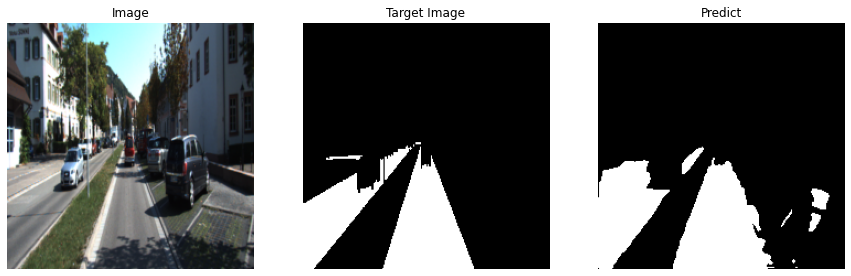

[Epoch 22/50]
    [Step : 5/20] Loss: 0.10419107228517532 Iou: 0.8266434669494629
    [Step : 10/20] Loss: 0.10894987732172012 Iou: 0.8092133402824402
    [Step : 15/20] Loss: 0.08891119062900543 Iou: 0.8525821566581726
    [Step : 20/20] Loss: 0.11253578960895538 Iou: 0.8296470046043396


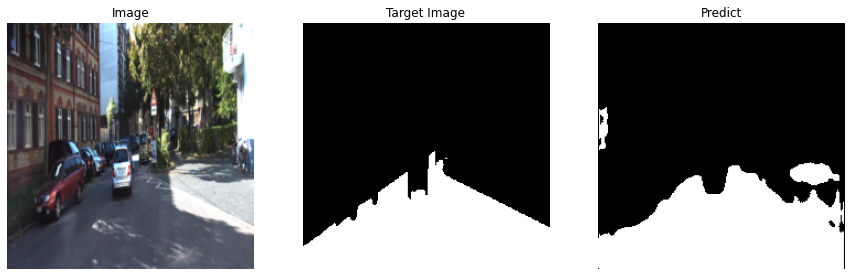

[Epoch 23/50]
    [Step : 5/20] Loss: 0.15850941836833954 Iou: 0.7339309453964233
    [Step : 10/20] Loss: 0.147455096244812 Iou: 0.7965189814567566
    [Step : 15/20] Loss: 0.09137608855962753 Iou: 0.8543439507484436
    [Step : 20/20] Loss: 0.13579274713993073 Iou: 0.7817751169204712


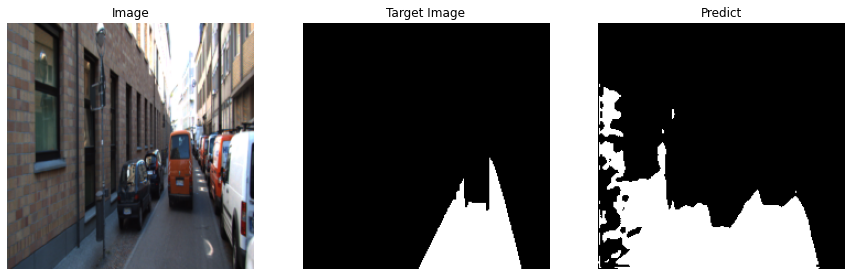

[Epoch 24/50]
    [Step : 5/20] Loss: 0.12012922018766403 Iou: 0.7867922782897949
    [Step : 10/20] Loss: 0.16124273836612701 Iou: 0.7058685421943665
    [Step : 15/20] Loss: 0.14298267662525177 Iou: 0.7547529935836792
    [Step : 20/20] Loss: 0.12053480744361877 Iou: 0.7863856554031372


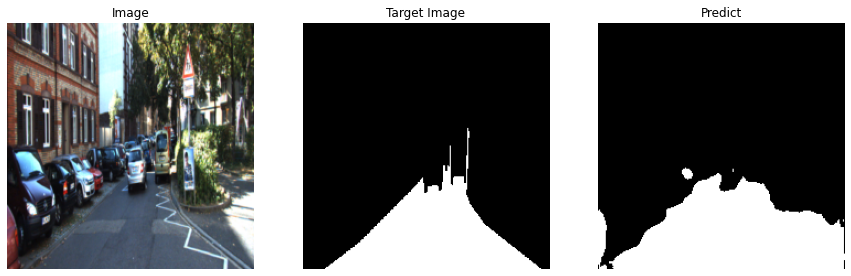

[Epoch 25/50]
    [Step : 5/20] Loss: 0.1297050416469574 Iou: 0.8172083497047424
    [Step : 10/20] Loss: 0.07991649955511093 Iou: 0.8898139595985413
    [Step : 15/20] Loss: 0.1921076476573944 Iou: 0.7225642800331116
    [Step : 20/20] Loss: 0.12098094820976257 Iou: 0.7743391394615173


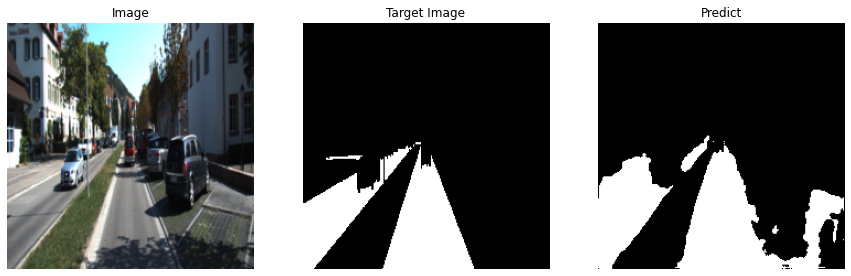

[Epoch 26/50]
    [Step : 5/20] Loss: 0.1354064643383026 Iou: 0.7795060873031616
    [Step : 10/20] Loss: 0.1153954491019249 Iou: 0.825964629650116
    [Step : 15/20] Loss: 0.09023912250995636 Iou: 0.842327356338501
    [Step : 20/20] Loss: 0.13275782763957977 Iou: 0.7679579854011536


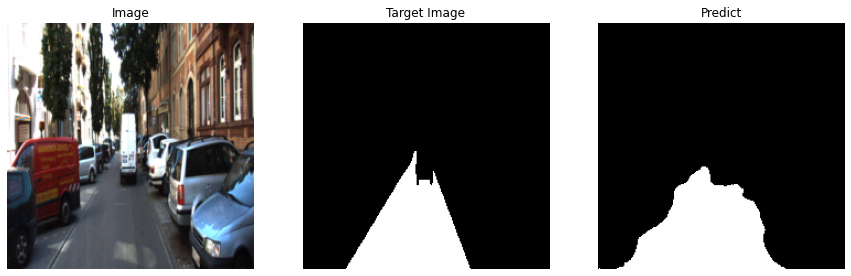

[Epoch 27/50]
    [Step : 5/20] Loss: 0.14535032212734222 Iou: 0.7668009996414185
    [Step : 10/20] Loss: 0.12202319502830505 Iou: 0.8154655694961548
    [Step : 15/20] Loss: 0.11616184562444687 Iou: 0.8213514089584351
    [Step : 20/20] Loss: 0.10077318549156189 Iou: 0.8444211483001709


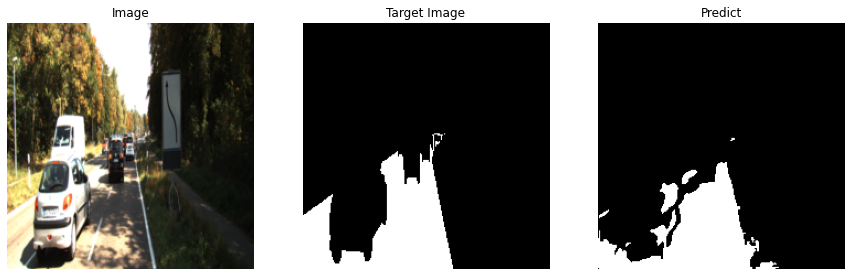

[Epoch 28/50]
    [Step : 5/20] Loss: 0.10118982195854187 Iou: 0.8310942053794861
    [Step : 10/20] Loss: 0.11353424191474915 Iou: 0.8069697618484497
    [Step : 15/20] Loss: 0.08180488646030426 Iou: 0.8819015026092529
    [Step : 20/20] Loss: 0.10484166443347931 Iou: 0.8562642931938171


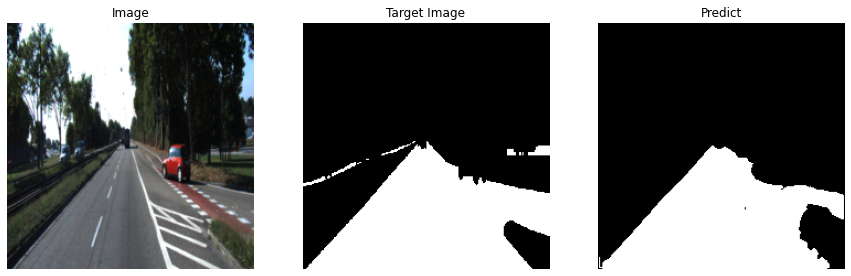

[Epoch 29/50]
    [Step : 5/20] Loss: 0.0815710723400116 Iou: 0.8471233248710632
    [Step : 10/20] Loss: 0.11540687829256058 Iou: 0.8147892951965332
    [Step : 15/20] Loss: 0.10479003190994263 Iou: 0.8178435564041138
    [Step : 20/20] Loss: 0.1093510091304779 Iou: 0.8272095322608948


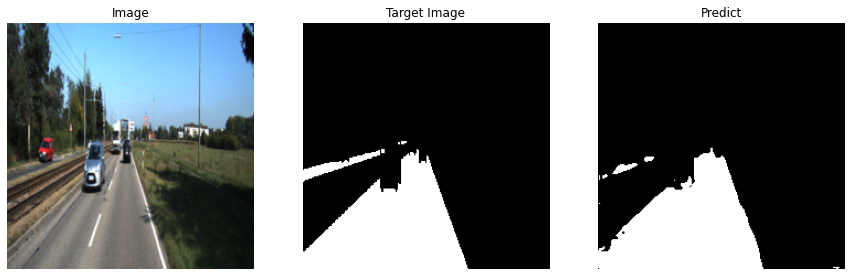

[Epoch 30/50]
    [Step : 5/20] Loss: 0.12165751308202744 Iou: 0.7979016304016113
    [Step : 10/20] Loss: 0.09397900849580765 Iou: 0.85000079870224
    [Step : 15/20] Loss: 0.09530611336231232 Iou: 0.8493276238441467
    [Step : 20/20] Loss: 0.09556123614311218 Iou: 0.8481390476226807


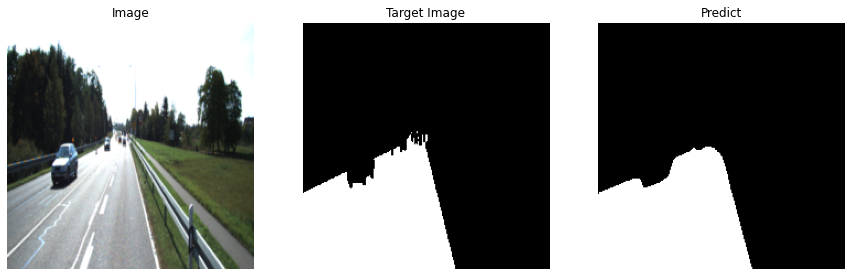

[Epoch 31/50]
    [Step : 5/20] Loss: 0.08881791681051254 Iou: 0.8601248860359192
    [Step : 10/20] Loss: 0.07076576352119446 Iou: 0.890719473361969
    [Step : 15/20] Loss: 0.08503621071577072 Iou: 0.8505128026008606
    [Step : 20/20] Loss: 0.09328212589025497 Iou: 0.8333047032356262


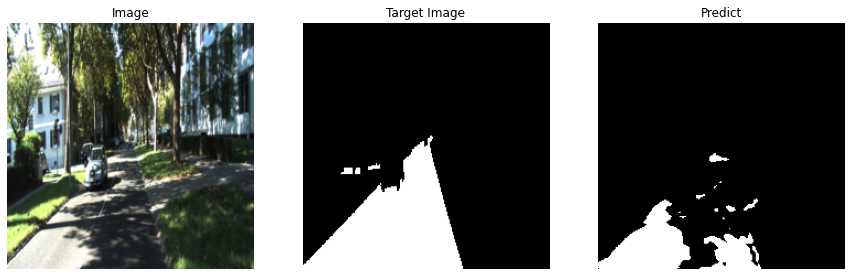

[Epoch 32/50]
    [Step : 5/20] Loss: 0.14201441407203674 Iou: 0.7414633631706238
    [Step : 10/20] Loss: 0.0997820571064949 Iou: 0.8503246903419495
    [Step : 15/20] Loss: 0.0936080664396286 Iou: 0.8848466873168945
    [Step : 20/20] Loss: 0.0996766984462738 Iou: 0.8421281576156616


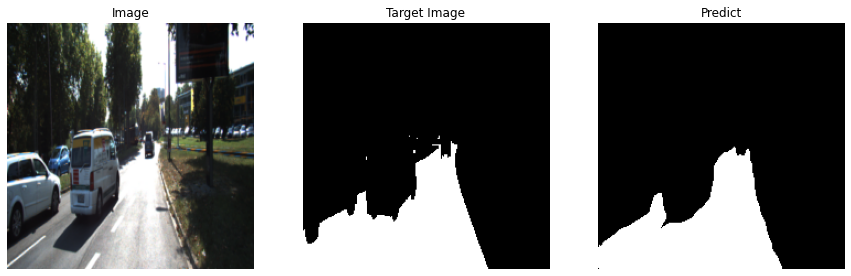

[Epoch 33/50]
    [Step : 5/20] Loss: 0.0885687842965126 Iou: 0.8463059663772583
    [Step : 10/20] Loss: 0.11722300201654434 Iou: 0.830092191696167
    [Step : 15/20] Loss: 0.12356530874967575 Iou: 0.8051405549049377
    [Step : 20/20] Loss: 0.15085454285144806 Iou: 0.7854177355766296


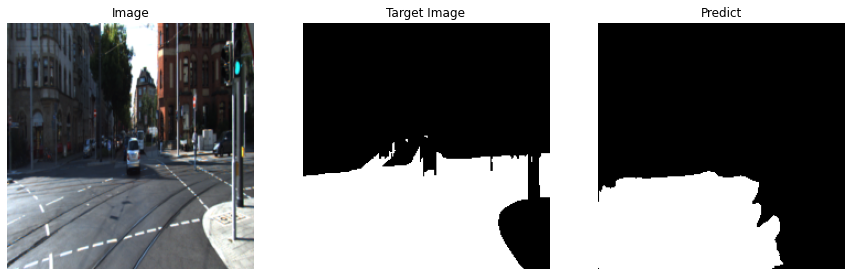

[Epoch 34/50]
    [Step : 5/20] Loss: 0.10302693396806717 Iou: 0.8340203166007996
    [Step : 10/20] Loss: 0.10520616918802261 Iou: 0.8148289918899536
    [Step : 15/20] Loss: 0.10227251052856445 Iou: 0.8187665343284607
    [Step : 20/20] Loss: 0.07343688607215881 Iou: 0.8763116598129272


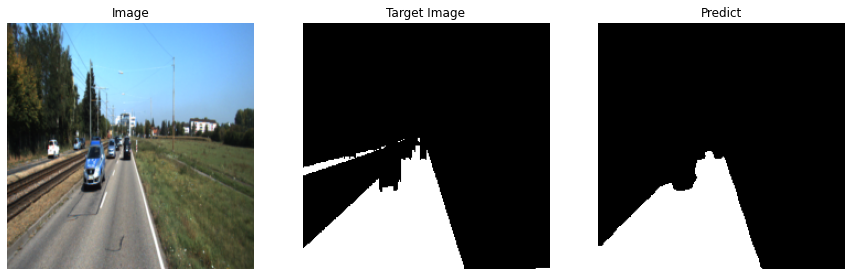

[Epoch 35/50]
    [Step : 5/20] Loss: 0.06912513077259064 Iou: 0.8824853301048279
    [Step : 10/20] Loss: 0.15092960000038147 Iou: 0.8073106408119202
    [Step : 15/20] Loss: 0.08417124301195145 Iou: 0.8800796270370483
    [Step : 20/20] Loss: 0.08950221538543701 Iou: 0.8618015646934509


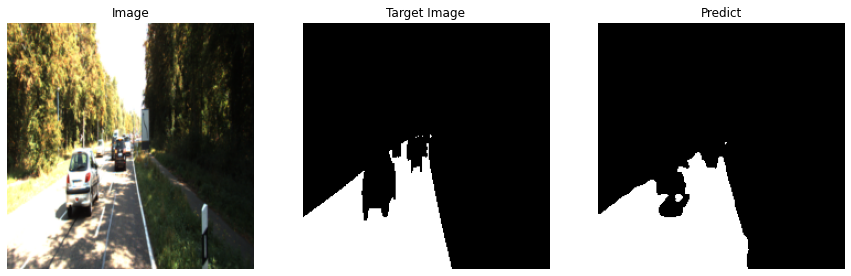

[Epoch 36/50]
    [Step : 5/20] Loss: 0.07391683757305145 Iou: 0.8880264163017273
    [Step : 10/20] Loss: 0.12279848754405975 Iou: 0.8219660520553589
    [Step : 15/20] Loss: 0.10090474039316177 Iou: 0.8600025773048401
    [Step : 20/20] Loss: 0.10626113414764404 Iou: 0.8254216909408569


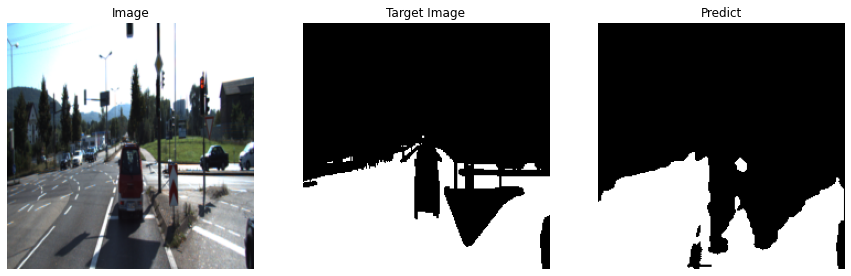

[Epoch 37/50]
    [Step : 5/20] Loss: 0.10034436732530594 Iou: 0.8291417360305786
    [Step : 10/20] Loss: 0.07649091631174088 Iou: 0.8786581158638
    [Step : 15/20] Loss: 0.09507771581411362 Iou: 0.8325838446617126
    [Step : 20/20] Loss: 0.14256447553634644 Iou: 0.7680047750473022


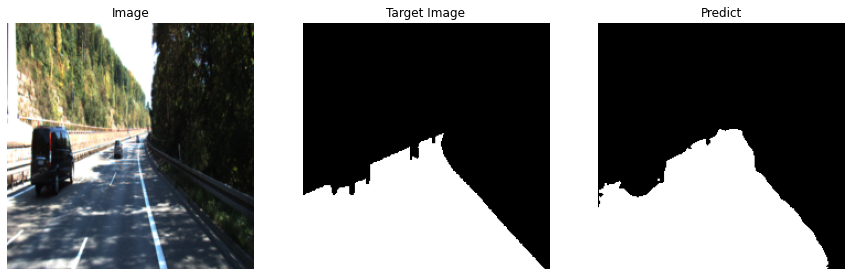

[Epoch 38/50]
    [Step : 5/20] Loss: 0.08217241615056992 Iou: 0.8717073798179626
    [Step : 10/20] Loss: 0.09895715117454529 Iou: 0.8254543542861938
    [Step : 15/20] Loss: 0.07194425165653229 Iou: 0.8798137903213501
    [Step : 20/20] Loss: 0.06200651824474335 Iou: 0.9088113903999329


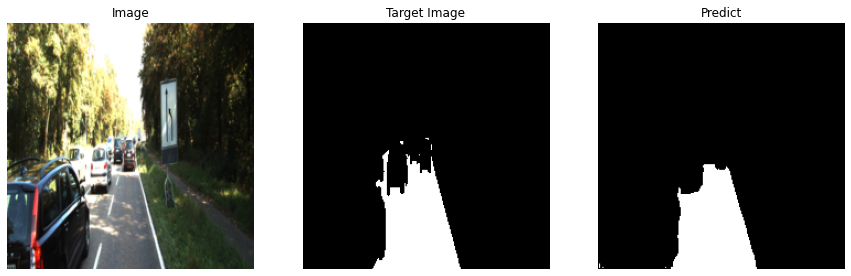

[Epoch 39/50]
    [Step : 5/20] Loss: 0.07272852957248688 Iou: 0.873532235622406
    [Step : 10/20] Loss: 0.08435117453336716 Iou: 0.8588593602180481
    [Step : 15/20] Loss: 0.12153653055429459 Iou: 0.8108350038528442
    [Step : 20/20] Loss: 0.11056553572416306 Iou: 0.8156554102897644


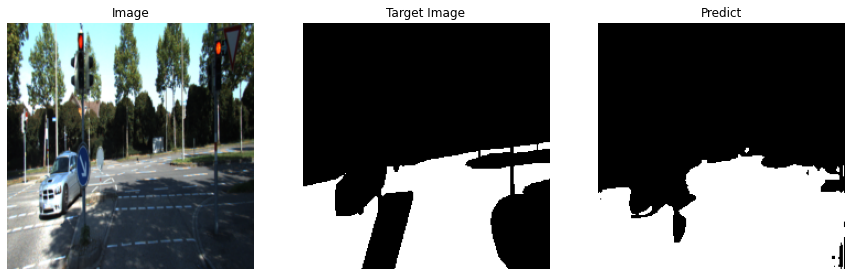

[Epoch 40/50]
    [Step : 5/20] Loss: 0.07615988701581955 Iou: 0.8668074011802673
    [Step : 10/20] Loss: 0.07854680716991425 Iou: 0.8730137944221497
    [Step : 15/20] Loss: 0.12412805110216141 Iou: 0.7958312034606934
    [Step : 20/20] Loss: 0.07366899400949478 Iou: 0.879996120929718


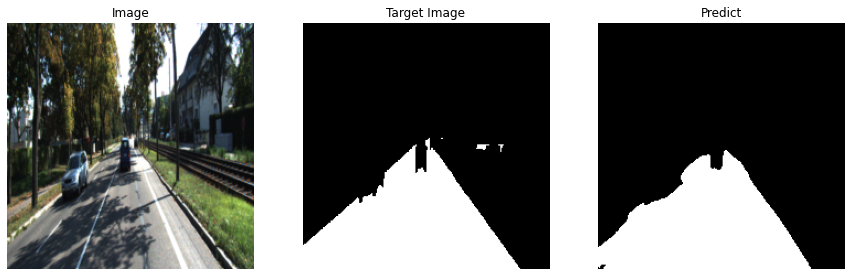

[Epoch 41/50]
    [Step : 5/20] Loss: 0.07816000282764435 Iou: 0.8722794055938721
    [Step : 10/20] Loss: 0.08830971270799637 Iou: 0.8535782098770142
    [Step : 15/20] Loss: 0.08055631071329117 Iou: 0.8751492500305176
    [Step : 20/20] Loss: 0.1046171635389328 Iou: 0.8267401456832886


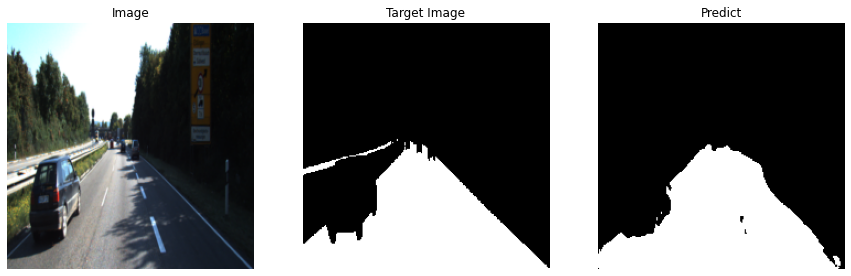

[Epoch 42/50]
    [Step : 5/20] Loss: 0.06763181835412979 Iou: 0.8973262906074524
    [Step : 10/20] Loss: 0.06789755076169968 Iou: 0.8829411268234253
    [Step : 15/20] Loss: 0.07107781618833542 Iou: 0.8719468116760254
    [Step : 20/20] Loss: 0.08169792592525482 Iou: 0.8925549983978271


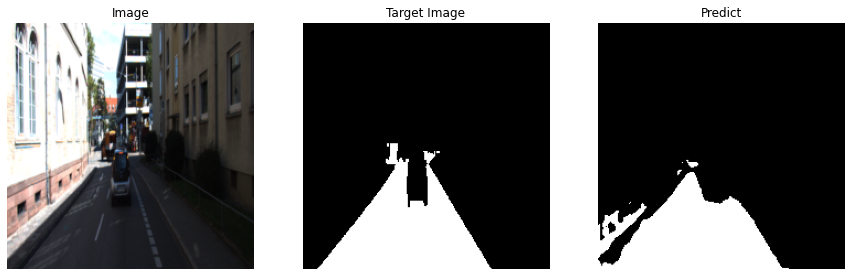

[Epoch 43/50]
    [Step : 5/20] Loss: 0.07637321949005127 Iou: 0.8683040142059326
    [Step : 10/20] Loss: 0.06900593638420105 Iou: 0.887676477432251
    [Step : 15/20] Loss: 0.05633000284433365 Iou: 0.9185294508934021
    [Step : 20/20] Loss: 0.1259080022573471 Iou: 0.8184666037559509


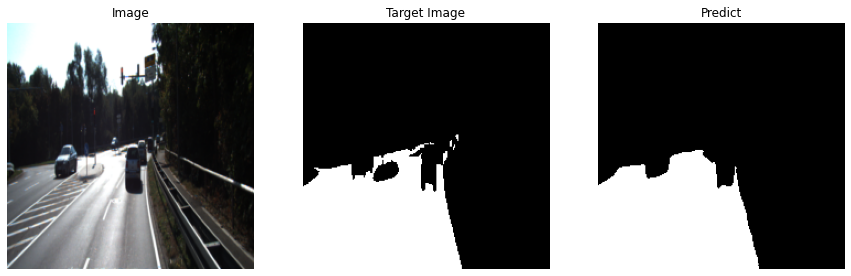

[Epoch 44/50]
    [Step : 5/20] Loss: 0.09744260460138321 Iou: 0.8636410236358643
    [Step : 10/20] Loss: 0.07273892313241959 Iou: 0.8723482489585876
    [Step : 15/20] Loss: 0.06586846709251404 Iou: 0.8763558268547058
    [Step : 20/20] Loss: 0.07302699983119965 Iou: 0.8760176301002502


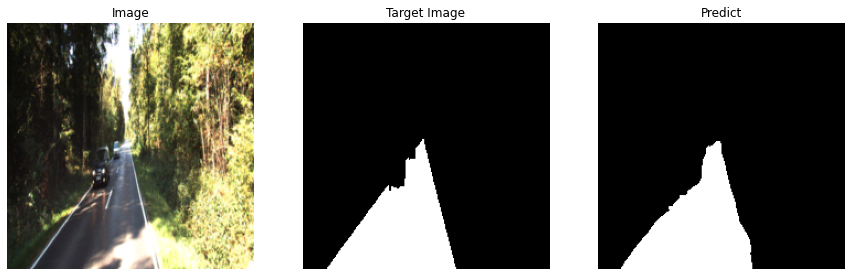

[Epoch 45/50]
    [Step : 5/20] Loss: 0.061176810413599014 Iou: 0.9063803553581238
    [Step : 10/20] Loss: 0.04990966618061066 Iou: 0.9226678013801575
    [Step : 15/20] Loss: 0.09234443306922913 Iou: 0.8726903796195984
    [Step : 20/20] Loss: 0.06887940317392349 Iou: 0.884088397026062


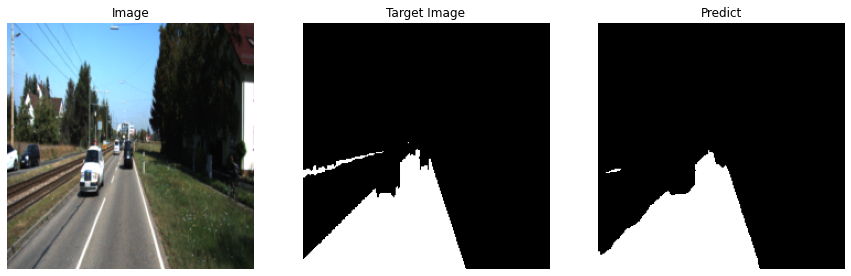

[Epoch 46/50]
    [Step : 5/20] Loss: 0.06517381221055984 Iou: 0.8967905640602112
    [Step : 10/20] Loss: 0.08351465314626694 Iou: 0.8790462017059326
    [Step : 15/20] Loss: 0.06267714500427246 Iou: 0.9055022597312927
    [Step : 20/20] Loss: 0.11799798905849457 Iou: 0.8139211535453796


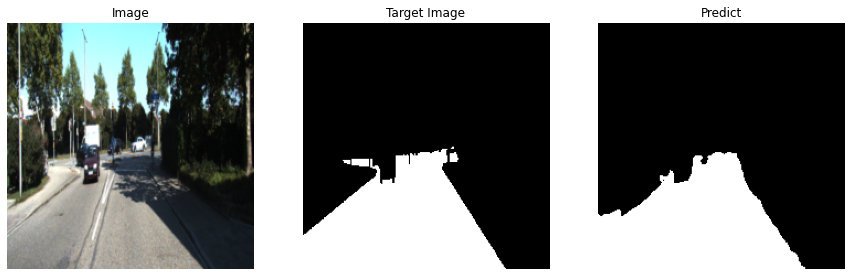

[Epoch 47/50]
    [Step : 5/20] Loss: 0.06596870720386505 Iou: 0.8788927793502808
    [Step : 10/20] Loss: 0.05077164247632027 Iou: 0.912643551826477
    [Step : 15/20] Loss: 0.07969167083501816 Iou: 0.8601503372192383
    [Step : 20/20] Loss: 0.050695937126874924 Iou: 0.9142261147499084


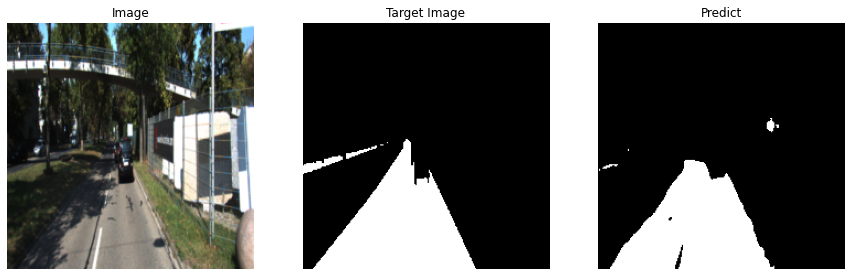

[Epoch 48/50]
    [Step : 5/20] Loss: 0.06334888190031052 Iou: 0.899101197719574
    [Step : 10/20] Loss: 0.07287000119686127 Iou: 0.8691296577453613
    [Step : 15/20] Loss: 0.05711131542921066 Iou: 0.884705662727356
    [Step : 20/20] Loss: 0.05849108472466469 Iou: 0.9014680981636047


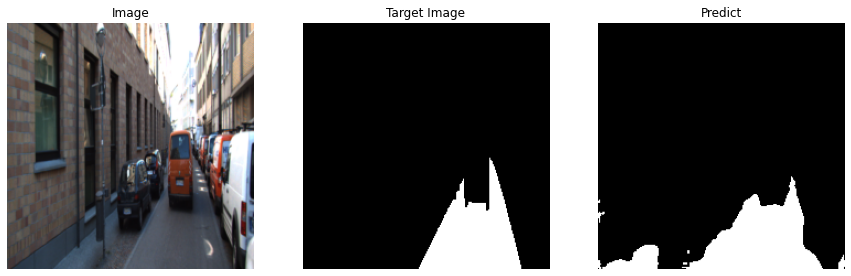

[Epoch 49/50]
    [Step : 5/20] Loss: 0.055430762469768524 Iou: 0.9070586562156677
    [Step : 10/20] Loss: 0.065218485891819 Iou: 0.8722975254058838
    [Step : 15/20] Loss: 0.08538554608821869 Iou: 0.845889687538147
    [Step : 20/20] Loss: 0.09444526582956314 Iou: 0.8635584115982056


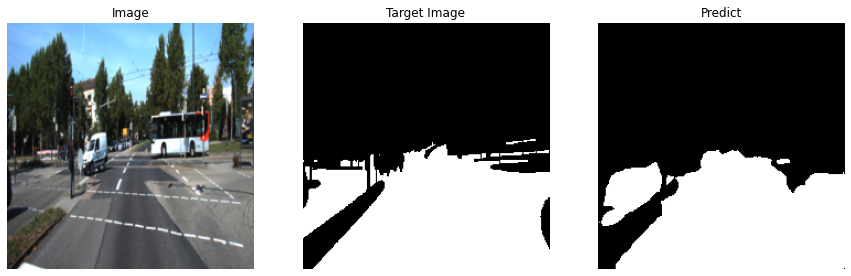

[Epoch 50/50]
    [Step : 5/20] Loss: 0.06201787292957306 Iou: 0.9040870070457458
    [Step : 10/20] Loss: 0.06384596228599548 Iou: 0.8967288732528687
    [Step : 15/20] Loss: 0.06649278849363327 Iou: 0.8850746750831604
    [Step : 20/20] Loss: 0.06699793040752411 Iou: 0.8777489066123962


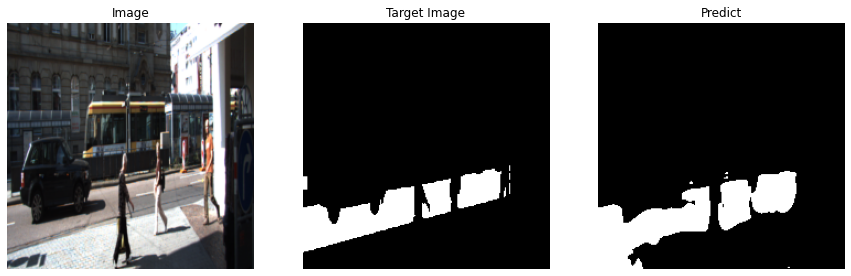

In [32]:
for epoch in range(1, epochs + 1):
    model.train()
    print(f'[Epoch {epoch}/{epochs}]')
    for idx, (imgs, trg_imgs) in enumerate(train_loader):
        imgs, trg_imgs = imgs.to(device), trg_imgs.to(device)

        outputs = model(imgs)
        loss = loss_fn(outputs, trg_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs = (outputs >= 0.5).int()

        if (idx + 1) % 5 == 0:
            current_iou = iou(outputs, trg_imgs)
            current_loss = loss.item()
            print(f'    [Step : {idx + 1}/{len(train_loader)}] Loss: {current_loss} Iou: {current_iou}')
    plt.figure(figsize=(15, 15))
    plt.subplot(131)
    plt.imshow(torch.permute(imgs[0], (1, 2, 0)).detach().cpu().numpy())
    plt.title('Image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(torch.squeeze(torch.squeeze(trg_imgs[0], 0), 0).detach().cpu().numpy(), 'gray')
    plt.title('Target Image')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(torch.squeeze(torch.squeeze(outputs[0], 0), 0).detach().cpu().numpy(), 'gray')
    plt.title('Predict')
    plt.axis('off')
    plt.show()